** Objective: ** 
** To develop a statistical model for predicting whether questions will be upvoted, downvoted, or closed based on their text. ** 
** To predict how long questions will take to answer. **

** Authors: Rachit Rawat, Rudradeep Guha, Vineet Nandkishore **

# 0. Setup Environment

In [ ]:
# load required packages

# for creating dataframes from csv datasets
import pandas as pd

# for regular expressions
import re

# for stripping stop words
from nltk.corpus import stopwords

# for TF-IDF
from textblob import TextBlob as tb

# for removing HTML tags from text body
from html.parser import HTMLParser

# for counting
import collections

# for scientific computing
import numpy as np
import math

# for plotting graphs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# magic function
%matplotlib inline

# kaggle - data set files are available in the "../input/" directory
dataset_dir = "../input/"
dataset_dir_questions = "Questions.csv"
dataset_dir_answers = "Answers.csv"
dataset_dir_tags = "Tags.csv"

# for offline run
# dataset_dir = "/home/su/Downloads/stacksample"

# list the files in the dataset directory
from subprocess import check_output
print(check_output(["ls", dataset_dir]).decode("utf8"))

cachedStopWords = stopwords.words("english")



Answers.csv
Questions.csv
Tags.csv



** 0.1 HTML tags Stripper class **

In [ ]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

** 0.2 TF-IDF helper fucntions **

In [ ]:
# tf(word, blob) computes "term frequency" which is the number of times 
# a word appears in a document blob,normalized by dividing by 
# the total number of words in blob. 
# We use TextBlob for breaking up the text into words and getting the word counts.
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

# n_containing(word, bloblist) returns the number of documents containing word.
# A generator expression is passed to the sum() function.
def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

# idf(word, bloblist) computes "inverse document frequency" which measures how common 
# a word is among all documents in bloblist. 
# The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents 
# to the number of documents containing word, then take the log of that. 
# Add 1 to the divisor to prevent division by zero.
def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

# tfidf(word, blob, bloblist) computes the TF-IDF score. 
# It is simply the product of tf and idf.
def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

# 1. Preprocessing
**1.1 pandas - load CSV into dataframe **


In [ ]:
# Read CSV

# Original Dimensionality - (rows, columns)

# (1264216, 7) 
# Columns (Id, OwnerUserId, CreationDate, ClosedDate, Score, Title, Body)
# frame every 1000th question (resource restraints)
questions_df = pd.read_csv(dataset_dir+dataset_dir_questions, encoding='latin1').iloc[::10000, :]

# (2014516, 6)
# Columns (Id, OwnerUserId, CreationDate, ParentId, Score, Body)
# frame every 1000th answer (resource restraints)
answers_df = pd.read_csv(dataset_dir+dataset_dir_answers, encoding='latin1').iloc[::1000, :]

# (3750994, 2)
# Columns (Id, Tag)
# frame every 1000th tag (resource restraints)
tags_df = pd.read_csv(dataset_dir+dataset_dir_tags, encoding='latin1').iloc[::1000, :]

**1.2 Sample dataframe before stripping **

In [ ]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10) 
# answers_df.head(10)
# tags_df.head(10) 

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
10000,637960,76691.0,2009-03-12T10:06:15Z,NaN,0,Continuous build with .NET and Java projects o...,<p>Is it possible to set up continuous build o...
20000,1114610,83846.0,2009-07-11T20:47:14Z,NaN,11,WiX: Installing Service as LocalService,<p>I am trying to get my application an instal...
30000,1549760,129701.0,2009-10-11T03:21:03Z,NaN,7,what language was cybersyn/cyberstride impleme...,<p>I am aware that it was implemented on the I...
40000,1971800,18853.0,2009-12-28T22:03:14Z,NaN,0,javac: package not found error,<p>I'm trying to compile a java file which imp...
50000,2372480,261192.0,2010-03-03T15:23:53Z,NaN,1,Why do some pages stall? (Ad Related),<p>I notice on bad quality websites with ads a...
60000,2751370,285411.0,2010-05-01T20:00:40Z,NaN,0,I18n translation problem,<p>I'm about to translate all time zones to Ru...
70000,3118400,363654.0,2010-06-25T13:34:14Z,NaN,2,How to submit an ASP.NET MVC form using javasc...,<p>I have an ASP.NET MVC 2 form that is workin...
80000,3481640,420123.0,2010-08-14T01:33:39Z,NaN,8,Custom Environment Variables in PHP,<p>Is there a way to set a custom variable suc...
90000,3835460,450062.0,2010-09-30T23:14:09Z,NaN,0,how do i solve a data conflict between string ...,<pre><code>#include&lt;iostream&gt;\n#include&...


**1.3 Strip HTML tags, stop words and symbols from text body and convert to lowercase **

In [ ]:
 # Remove HTML tags, stop words, symbols from body and title column and convert to lowercase
for index, row in questions_df.iterrows():
    questions_df.at[index, 'Body']= ' '.join([word for word in re.sub(r'[^\w]', ' ', strip_tags(row[6])).lower().split() if word not in cachedStopWords])
    questions_df.at[index, 'Title']= ' '.join([word for word in re.sub(r'[^\w]', ' ', strip_tags(row[5])).lower().split() if word not in cachedStopWords])

 # Remove HTML tags, stop words, symbols from body and convert to lowercase
for index, row in answers_df.iterrows():
    answers_df.at[index, 'Body']= ' '.join([word for word in re.sub(r'[^\w]', ' ', strip_tags(row[5])).lower().split() if word not in cachedStopWords]) 

**1.4 Sample dataframe after stripping **

In [ ]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10)
# answers_df.head(10)
# tags_df.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,sqlstatement execute multiple queries one stat...,written database generation script sql want ex...
10000,637960,76691.0,2009-03-12T10:06:15Z,NaN,0,continuous build net java projects single machine,possible set continuous build projects written...
20000,1114610,83846.0,2009-07-11T20:47:14Z,NaN,11,wix installing service localservice,trying get application installer via wix 3 0 e...
30000,1549760,129701.0,2009-10-11T03:21:03Z,NaN,7,language cybersyn cyberstride implemented,aware implemented ibm 360 mainframe architectu...
40000,1971800,18853.0,2009-12-28T22:03:14Z,NaN,0,javac package found error,trying compile java file imports packages crea...
50000,2372480,261192.0,2010-03-03T15:23:53Z,NaN,1,pages stall ad related,notice bad quality websites ads piece site loa...
60000,2751370,285411.0,2010-05-01T20:00:40Z,NaN,0,i18n translation problem,translate time zones russian done things model...
70000,3118400,363654.0,2010-06-25T13:34:14Z,NaN,2,submit asp net mvc form using javascript still...,asp net mvc 2 form working perfectly client si...
80000,3481640,420123.0,2010-08-14T01:33:39Z,NaN,8,custom environment variables php,way set custom variable environment_name apach...
90000,3835460,450062.0,2010-09-30T23:14:09Z,NaN,0,solve data conflict string infile open,include iostream include fstream include cstdl...


** 1.5 Make a TF-IDF word dictionary **

In [ ]:
tfidf_dict={}
bloblist=[]
idlist=[]

for index, row in questions_df.iterrows():
    # also append title to text body
    bloblist.append(tb(row[6]+" "+row[5]))
    idlist.append(row[0])

for i, blob in enumerate(bloblist):
    print("Top words in question ID {}".format(idlist[i]))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))
        tfidf_dict[word]=[round(score, 5), idlist[i]]

Top words in question ID 80
	Word: sqlstatement, TF-IDF: 0.16993
	Word: integer, TF-IDF: 0.15133
	Word: sqlconnection, TF-IDF: 0.14565
Top words in question ID 637960
	Word: projects, TF-IDF: 0.36542
	Word: build, TF-IDF: 0.26973
	Word: machine, TF-IDF: 0.23669
Top words in question ID 1114610
	Word: localservice, TF-IDF: 0.13837
	Word: service, TF-IDF: 0.13235
	Word: myprogramserviceinstaller, TF-IDF: 0.10378
Top words in question ID 1549760
	Word: implemented, TF-IDF: 0.19714
	Word: ibm, TF-IDF: 0.14565
	Word: 360, TF-IDF: 0.14565
Top words in question ID 1971800
	Word: import, TF-IDF: 0.32867
	Word: java, TF-IDF: 0.28629
	Word: commchange, TF-IDF: 0.25677
Top words in question ID 2372480
	Word: stall, TF-IDF: 0.49812
	Word: site, TF-IDF: 0.24419
	Word: load, TF-IDF: 0.22118
Top words in question ID 2751370
	Word: ð, TF-IDF: 0.25311
	Word: i18n, TF-IDF: 0.15187
	Word: z, TF-IDF: 0.13703
Top words in question ID 3118400
	Word: submit, TF-IDF: 0.22166
	Word: form, TF-IDF: 0.18664
	Word

	Word: ratings, TF-IDF: 0.24599
	Word: fb, TF-IDF: 0.18449
	Word: graph, TF-IDF: 0.18449
Top words in question ID 24490080
	Word: query, TF-IDF: 0.24687
	Word: network, TF-IDF: 0.15862
	Word: err, TF-IDF: 0.13745
Top words in question ID 24804030
	Word: migration, TF-IDF: 0.3257
	Word: rails, TF-IDF: 0.25057
	Word: rb, TF-IDF: 0.20046
Top words in question ID 25115170
	Word: null, TF-IDF: 0.19041
	Word: 05, TF-IDF: 0.14048
	Word: 2014, TF-IDF: 0.09361
Top words in question ID 25426090
	Word: rep, TF-IDF: 0.06695
	Word: progress, TF-IDF: 0.06695
	Word: totalbytessent, TF-IDF: 0.06695
Top words in question ID 25740430
	Word: oldextension, TF-IDF: 0.2965
	Word: file, TF-IDF: 0.23802
	Word: newextension, TF-IDF: 0.22238
Top words in question ID 26054280
	Word: jwplayer, TF-IDF: 0.33886
	Word: video, TF-IDF: 0.21171
	Word: repeat, TF-IDF: 0.15288
Top words in question ID 26368490
	Word: clients, TF-IDF: 0.1611
	Word: datatable, TF-IDF: 0.1339
	Word: scope, TF-IDF: 0.10435
Top words in quest

**1.6 Sample [TF-IDF, ID] dictionary **

In [ ]:
for k, v in tfidf_dict.items():
    print(k, v)

sqlstatement [0.16993, 80]
integer [0.15133, 80]
sqlconnection [0.14565, 80]
projects [0.36542, 637960]
build [0.10499, 39810190]
machine [0.17553, 15133550]
localservice [0.13837, 1114610]
service [0.31764, 38500300]
myprogramserviceinstaller [0.10378, 1114610]
implemented [0.19714, 1549760]
ibm [0.14565, 1549760]
360 [0.14565, 1549760]
import [0.32867, 1971800]
java [0.28629, 1971800]
commchange [0.25677, 1971800]
stall [0.49812, 2372480]
site [0.24419, 2372480]
load [0.22118, 2372480]
ð [0.25311, 2751370]
i18n [0.15187, 2751370]
z [0.13703, 2751370]
submit [0.22166, 3118400]
form [0.2701, 21658840]
side [0.15966, 3118400]
environment_name [0.48836, 3481640]
custom [0.40681, 3481640]
vhost [0.24418, 3481640]
cout [0.133, 7954010]
infile [0.17166, 3835460]
read [0.21543, 27624740]
array [0.09142, 21015590]
nsstring [0.21713, 4188700]
calculatevalue [0.18048, 4188700]
parallel [0.12209, 4539310]
jobs [0.12209, 4539310]
pool [0.10465, 4539310]
within [0.12441, 4889370]
polling [0.10644,

In [ ]:
def predict(rawQ):
    # strip stop words, symbols and convert to lowercase
    strippedQ= ' '.join([word for word in re.sub(r'[^\w]', ' ', rawQ).lower().split() if word not in cachedStopWords])
    termList=strippedQ.split()
    
    print(termList)
    

In [ ]:
inputQ="How to delete a table in SQL?"
predict(inputQ)

['delete', 'table', 'sql']


# Initial analysis

** Top 10 most common tags **

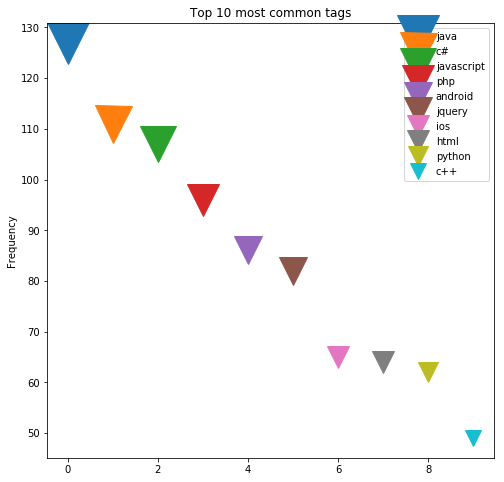

In [ ]:
tags_tally = collections.Counter(tags_df['Tag'])

# x = tag name, y = tag frequency
x, y = zip(*tags_tally.most_common(10))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

area = [i/3 for i in list(y)]   # 0 to 15 point radiuses
plt.figure(figsize=(8,8))
plt.ylabel("Frequency")
plt.title("Top 10 most common tags")
for i in range(len(y)):
        plt.plot(i,y[i], marker='v', linestyle='',ms=area[i],label=x[i])

plt.legend(numpoints=1)
plt.show()

**Distribution  - number of answers per question**

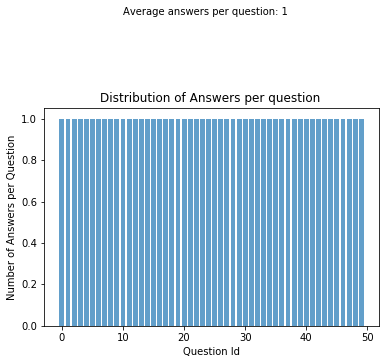

In [ ]:
ans_per_question = collections.Counter(answers_df['ParentId'])
answerid,noAnswers= zip(*ans_per_question.most_common())

N=50
plt.bar(range(N), noAnswers[:N], align='center', alpha=0.7)
#plt.xticks(y_pos, objects)

plt.ylabel('Number of Answers per Question')
plt.xlabel('Question Id')
plt.title('Distribution of Answers per question ')
plt.text(10,1.5,"Average answers per question: "+str(math.floor((np.mean(noAnswers)))))

plt.show()